In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch as th
import torch.nn as nn


from forexgym.utils import Query
from forexgym.envs import DiscreteActionEnvironment

In [5]:
def article_processor(df: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
    df["x1"] = ((df["Close"] - df["Close"].shift(1) ) / df["Close"]).shift(1) 
    df["x2"] = ((df["High"] - df["High"].shift(1) ) / df["High"]).shift(1) 
    df["x3"] = ((df["Low"] - df["Low"].shift(1) ) / df["Low"]).shift(1) 
    df["x4"] = (df["High"] - df["Close"]) / df["Close"] 
    df["x5"] = (df["Close"] - df["Low"]) / df["Close"] 
    
    return df.drop(["Date", "Open", "High", "Low", "Close"], axis=1)

ticker = "EURUSD"
#timeframes = ["1m", "5m", "15m", "30m", "1H", "4H", "1D"]
timeframes = ["15m", "1H"]

query = Query(episode_length=256, trading_timeframe="15m", trading_column="Close")
# query.add_query(
#     timeframe="4H",
#     window_size=4,
#     data_processor=article_processor
# )
query.add_query(
    timeframe="15m",
    window_size=16,
    data_processor=article_processor
)
query.add_query(
    timeframe="1H",
    window_size=4,
    data_processor=article_processor
)
# query.add_query(
#     timeframe="15m",
#     window_size=4,
#     data_processor=article_processor
# )
# dataset = pair.generate_dataset(query)

env = DiscreteActionEnvironment(
    currency_tickers={"EURUSD": timeframes},
    query=query,
    reward_type="continuous",
    reward_multiplier=1e3,
    episode_length=256,
    allow_holding=True
)

100%|██████████| 2/2 [00:00<00:00, 30.08it/s]


Generated EURUSD dataset.


In [6]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [7]:
class Network(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, hidden_size: int = 128, n_layers: int = 2):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_inputs, hidden_size),
            *[
                nn.ReLU() if i % 2 == 0 else nn.Linear(hidden_size, hidden_size) for i in range(n_layers*2)
            ],
            nn.ReLU(),
            nn.Linear(hidden_size, n_outputs),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: th.Tensor) -> th.Tensor:
        return self.softmax(self.layers(x))

In [8]:
batch_size = 64

In [9]:
df = pd.read_csv("datasets/training/EURUSD.csv")
df["Lable"] = (df["Trading_Price"].shift(-1)-df["Trading_Price"]).apply(lambda x: 1 if x > 0 else 0)
df = df.dropna()
features = th.from_numpy(df.drop(["Date", "Trading_Price", "Lable"], axis=1).to_numpy()).to(device=device).type(th.float32)
lable = th.from_numpy(df["Lable"].to_numpy()).to(device=device)
lable = nn.functional.one_hot(lable, num_classes=2).type(th.float32)
df.head()

,Date,Trading_Price,15m_x1_0,15m_x2_0,15m_x3_0,15m_x4_0,15m_x5_0,15m_x1_1,15m_x2_1,15m_x3_1,...,1H_x2_2,1H_x3_2,1H_x4_2,1H_x5_2,1H_x1_3,1H_x2_3,1H_x3_3,1H_x4_3,1H_x5_3,Lable
0,2023-09-20 06:00:00+00:00,1.06866,-0.000056,-0.000225,-0.000159,0.000122,0.001263,0.000037,0.000215,0.000187,...,0.000206,0.000253,0.000440,0.000122,0.000131,0.000159,0.000066,0.000627,0.000028,1
1,2023-09-20 06:15:00+00:00,1.06902,0.000515,0.000580,-0.000581,0.000140,0.000384,-0.000056,-0.000225,-0.000159,...,0.000206,0.000253,0.000440,0.000122,0.000131,0.000159,0.000066,0.000627,0.000028,1
2,2023-09-20 06:30:00+00:00,1.06926,0.000337,0.000355,0.001217,0.000028,0.000430,0.000515,0.000580,-0.000581,...,0.000206,0.000253,0.000440,0.000122,0.000131,0.000159,0.000066,0.000627,0.000028,0
3,2023-09-20 06:45:00+00:00,1.06820,0.000224,0.000112,0.000178,0.001048,0.000047,0.000337,0.000355,0.001217,...,0.000206,0.000253,0.000440,0.000122,0.000131,0.000159,0.000066,0.000627,0.000028,0
4,2023-09-20 07:00:00+00:00,1.06769,-0.000992,0.000028,-0.000609,0.000693,0.000009,0.000224,0.000112,0.000178,...,-0.000515,-0.000421,0.000234,0.000037,-0.000300,0.000206,0.000253,0.000440,0.000122,1


In [10]:
features.shape, lable.shape

(torch.Size([25055, 100]), torch.Size([25055, 2]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, lable, test_size=0.2, random_state=42)

In [16]:
epochs = 10000
learning_rate = 0.0005

model = Network(
    n_inputs=features.shape[1],
    n_outputs=2,
    hidden_size=256,
    n_layers=3
).to(device=device)

lossfn = nn.CrossEntropyLoss()
optimiser = th.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
model.layers

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=2, bias=True)
)

In [18]:
confidence_threshold = 0.8

In [19]:
model.train()
for epoch in range(epochs):
    y_pred = model(X_train)
    optimiser.zero_grad()
    loss = lossfn(y_pred, y_train)
    loss.backward()
    th.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimiser.step()
    
    
    if epoch % 100 == 0:
        model.eval()
        with th.inference_mode():
            y_pred = model(X_test)
        confident_indices = np.where(y_pred.cpu() >= confidence_threshold)[0]   
        pred_filtered = y_test.argmax(dim=1).unsqueeze(dim=1).cpu()[confident_indices].detach().cpu().numpy()
        test_filtered = th.argmax(y_pred, dim=1).unsqueeze(dim=1).cpu()[confident_indices].detach().cpu().numpy()
        acc = sum(pred_filtered == test_filtered) / max(len(y_pred[confident_indices]), 1)
        try:
            f1 = f1_score(test_filtered, pred_filtered)
        except:  # noqa: E722 ik this bad, but it works
            f1 = 0
        loss = lossfn(y_pred, y_test)
        
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | F1: {f1}")
        
    model.train()

Epoch: 0 | Loss: 0.693128228187561 | Accuracy: 0.0 | F1: 0
Epoch: 100 | Loss: 0.6931772232055664 | Accuracy: 0.0 | F1: 0
Epoch: 200 | Loss: 0.6931761503219604 | Accuracy: 0.0 | F1: 0
Epoch: 300 | Loss: 0.6931235790252686 | Accuracy: 0.0 | F1: 0
Epoch: 400 | Loss: 0.6937114000320435 | Accuracy: 0.0 | F1: 0
Epoch: 500 | Loss: 0.6943509578704834 | Accuracy: [0.33333333] | F1: 0.0
Epoch: 600 | Loss: 0.6943963766098022 | Accuracy: [0.4] | F1: 0.0
Epoch: 700 | Loss: 0.6949750185012817 | Accuracy: [0.5] | F1: 0.0
Epoch: 800 | Loss: 0.6952784061431885 | Accuracy: [0.5] | F1: 0.0
Epoch: 900 | Loss: 0.6960248947143555 | Accuracy: [0.5] | F1: 0.0
Epoch: 1000 | Loss: 0.6958256959915161 | Accuracy: [0.4] | F1: 0.0
Epoch: 1100 | Loss: 0.6955059170722961 | Accuracy: [0.5] | F1: 0.0
Epoch: 1200 | Loss: 0.6956354975700378 | Accuracy: [0.66666667] | F1: 0.0


c:\Users\Carlos\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 1300 | Loss: 0.695771336555481 | Accuracy: [1.] | F1: 0.0
Epoch: 1400 | Loss: 0.6958630084991455 | Accuracy: 0.0 | F1: 0
Epoch: 1500 | Loss: 0.6960798501968384 | Accuracy: 0.0 | F1: 0


c:\Users\Carlos\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 1600 | Loss: 0.6973121166229248 | Accuracy: [1.] | F1: 0.0


c:\Users\Carlos\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch: 1700 | Loss: 0.6951082348823547 | Accuracy: [1.] | F1: 0.0
Epoch: 1800 | Loss: 0.6966803669929504 | Accuracy: [0.66666667] | F1: 0.0
Epoch: 1900 | Loss: 0.6981440186500549 | Accuracy: [0.5] | F1: 0.0
Epoch: 2000 | Loss: 0.6983193755149841 | Accuracy: [0.4] | F1: 0.0
Epoch: 2100 | Loss: 0.6985597610473633 | Accuracy: [0.33333333] | F1: 0.0
Epoch: 2200 | Loss: 0.7007835507392883 | Accuracy: [0.33333333] | F1: 0.0
Epoch: 2300 | Loss: 0.6987282037734985 | Accuracy: [0.5] | F1: 0.0
Epoch: 2400 | Loss: 0.7003363370895386 | Accuracy: [0.5] | F1: 0.0
Epoch: 2500 | Loss: 0.7004687190055847 | Accuracy: [0.57142857] | F1: 0.5714285714285715
Epoch: 2600 | Loss: 0.699497401714325 | Accuracy: [0.38888889] | F1: 0.42105263157894735
Epoch: 2700 | Loss: 0.7005221247673035 | Accuracy: [0.42857143] | F1: 0.4666666666666667
Epoch: 2800 | Loss: 0.7011530995368958 | Accuracy: [0.44186047] | F1: 0.45454545454545453
Epoch: 2900 | Loss: 0.7018604874610901 | Accuracy: [0.38297872] | F1: 0.382978723404255

KeyboardInterrupt: 

In [27]:
th.save(model, "models/supervised_02.pt")

In [96]:
model.forward(th.Tensor([[0]]).to(device=device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 6x256)

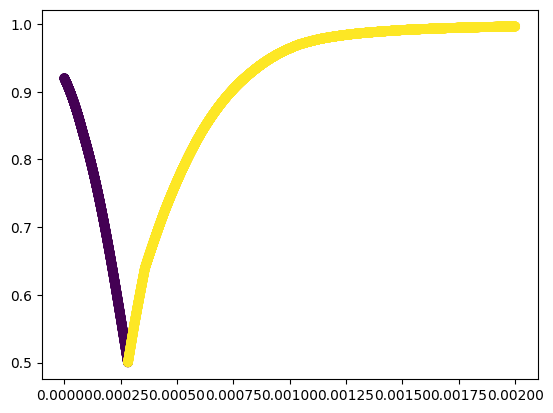

In [168]:
x = th.linspace(0, 0.002, 10000)
y, pred = model.forward(x.unsqueeze(dim=1).to(device=device)).max(dim=1)
y = y.detach().cpu().numpy()
pred = pred.detach().cpu().numpy()
plt.scatter(x, y, c=pred)

    



In [170]:
df["15m_x5_0"].describe()

count    75223.000000
mean         0.000242
std          0.000281
min          0.000000
25%          0.000073
50%          0.000165
75%          0.000319
max          0.008235
Name: 15m_x5_0, dtype: float64